# SNIP Fit Analysis
**In this notebook, we use the fits computed from Pymca's SNIP tool to analyze 1) Which angle and detector combination allows for the cleanest HfO2 spectrum to be obtained, and 2) Which SNIP parameters allow for the cleanest removal of diffraction peaks/background radiation while preserving the Hf counts.**

*Date: 07/11/2024*

*Author: Sonia Ghoshal, NIST SURF*

## Table of Contents: 

1.1 Setup 

1.2 Imports

1.3 .fit File Reading

2.0 Which Angle is Best?

    A. Reading the Hf L counts 
    B. Examining the principal peak counts for various angles and thicknesses
    C. Analysis of best angle

2.3 Visualizing the L2 and L3 Peak Fits ***move this section up after "Which Angle is the Best"**


3.0 Visualizing the Hf Spectrum

    A. Plotting the 6nm HfO2 Spectrum, its pymca fit, and the continuum
    B. Zoomed in Graph

4.0 Removing Background Radiation 

    A. Subtracting continuum from spectrum
    B. Plotting the continuum models under various SNIP widths
    C. Plotting the "cleaned up" (continuum-removed) signals under various SNIP widths

5.0 Which SNIP Width is the Best?



--------------------------------------------------------------------------------------------------------------------------------------------------------


## 1.1 Setup
### Chip Details:
* type: KRISS K157 #502
* thicknesses: 6.0nm, 3.0nm, 2.0nm HfO2
* composition: HfO2 nanofilm over Si substrate
### Experiment summary: 
* initially took mXRF scans at rotations of angles 0, 10, 20, 30, 40, 50, 60, 70, 80, 90
* each measurement consisted of 10 Detector 1 (D1) scans and 10 Detector 2 (D2) scans
* observed that angle 40 and D1 scans allowed for the best isolation of Hf peaks
* took measurements at angles 32, 34, 36, 38, 40, 42, 44, 46, 48
* angle 40 once again seemed to be the best angle
* Here, we use the 9th D1 scan (D1_8) for consistency, but eventually we want to average all of the D1 scans at angle 40
* path to data: C:\Users\sng38\SURF_XRF_FY24\surf_xrf_fy24\data\raw\20240626_K157_6nm_Rotation\40_deg\20240626_K157_6nm_Rotation_40_deg_repeat_Rh_FE_D1_0_8.spx

## 1.2 Imports

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import glob
import os

## 1.3 .fit File Reading

In [5]:
def readFitFile(path):
    fit = open(path)

    #ignore the [info] section. We only care about [results] section
    line = fit.readline()
    while("result") not in line:
       line = fit.readline()

    # there is a space between every number, so we split up the array by spaces
    # by doing so, we have unwanted items "xdata', "=", and "[ " in the array, which we exclude by starting at index 3
    xdata = np.array(fit.readline().split(" ")[3:-1], dtype=float)
    energy = np.array(fit.readline().split(" ")[3:-1], dtype=float)
    ydata = np.array(fit.readline().split(" ")[3:-1], dtype=float)
    yfit = np.array(fit.readline().split(" ")[3:-1], dtype=float)
    continuum = np.array(fit.readline().split(" ")[3:-1], dtype=float)

    fit.close()
    
    return xdata, energy, ydata, yfit, continuum

In [62]:
os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\interim\\K157_6nm_Rotation_40_D1_Fit1\\")
data = {}
for i in ["5", "10", "20", "30", "45", "60"]:
    data[i] = readFitFile(glob.glob("20240626_K157_6nm_Rotation_40_deg_D1_tr8_" + i + "SNIP.fit")[0])


In [61]:
# WORK IN PROGRESS FOR MULTIPLE THICKNESSES
#MOVE DOWN

# os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\interim\\K157_Rotation_40_D1_Fit1\\")
# data = {}
# for j in ["6.0", "3.0", "2.0"]:
#     data[j] = {}
# for i in ["5", "10", "20", "30", "45", "60"]:
#      data["6.0"][i] = readFitFile(glob.glob("20240626_K157_6nm_Rotation_40_deg_D1_tr8_" + i + "SNIP.fit")[0])
# #     data["3.0"][i] = readFitFile(glob.glob("20240626_K157_3nm_Rotation_40_deg_D1_tr8_" + i + "SNIP.fit")[0])
# #     data["2.0"][i] = readFitFile(glob.glob("20240626_K157_2nm_Rotation_40_deg_D1_tr8_" + i + "SNIP.fit")[0])

# data

# os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\interim\\K157_Rotation_45_D2_Fits")

# fit_45D2 = {}
# for i in ['2', '3', '6']:
#     for j in range(10):
#         fit_45D2[i][j] = readFitFile(glob.glob("2024*_K157_" + str(i) + "nm_Rotation_45_deg_repeat_Rh_FE_D2_0_" + str(j) + 
#                                                          "*.fit")[0])[2]


**Summary:**
Now, we have collected the data from the .fit file and arranged it in a 4D array. The first index (String type) corresponds to the thickness, the second index (String type) corresponds to the SNIP width (5, 10, 20, 30, 45, or 60) and the third index (float type) corresponds to the type of data (xdata, energy, ydata, yfit, or continuum). 

`data['thickness']['width'][0]` gives an array of xdata (channels) 

`data['thickness']['width'][1]` gives an array of energy

`data['thickness']['width'][2]` gives an array of ydata coordinates

`data['thickness']['width'][3]` gives an array of yfit coordinates

`data['thickness']['width'][4]` gives an array of continuum (y-coordinates)


## 2.1 Which Angle is the Best?
**In this section, we use the .fit file data to calculate the area under the curve of the principal peak of Hf (L3). We calculate this area for the original spectra and all of the "cleaned" spectra with varying SNIP widths. We undergo these calculations for wafers of different thicknesses (6.0nm, 3.0nm, 2.0nm), and observe whether the calculated principal peak counts are proportional to the thicknesses of the wafers.**

#### 2.1.1: Visualizing Hf Principal Peak Fits

##### We use a 40 degree 6nm scan as an example to visualize the Hf peaks.

In [63]:
os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\interim\\K157_6nm_Rotation_40_D1_Fit1\\")
data_peaks = {}
for i in ["5", "10", "20", "30", "45", "60"]:
    data_peaks[i] = readPeakCounts(glob.glob("20240626_K157_6nm_Rotation_40_deg_D1_tr8_" + i + "SNIP.fit")[0])

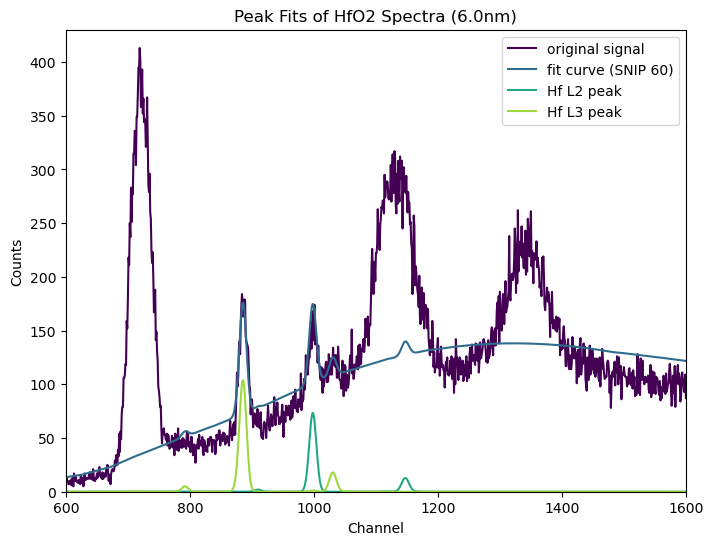

In [64]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlim(xmin = 600, xmax = 1600)
ax.set_ylim(ymin = 0, ymax = 430)
ax.set_title("Peak Fits of HfO2 Spectra (6.0nm)")
ax.set_xlabel("Channel")
ax.set_ylabel("Counts")
ax.plot(data["60"][0],data["60"][2], color = cmap(0), label = "original signal")
ax.plot(data["60"][0], data["60"][3], color = cmap(0.35), label = "fit curve (SNIP 60)")
#ax.plot(data["60"][0], data_peaks["60"][0], color = 'r', label= "yHf L peaks")
#ax.plot(data["60"][0], data_peaks["60"][1], color = 'g', label= "yHf L1 peaks")
ax.plot(data["60"][0], data_peaks["60"][2], color = cmap(0.6), label= "Hf L2 peak")
ax.plot(data["60"][0], data_peaks["60"][3], color = cmap(0.85), label= "Hf L3 peak")
ax.legend()

#os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\processed\\figures")
#plt.savefig("Peak_Fits_HfO2_6nm_Rot40_SNIP60")


plt.show()

#### 2.1.2: Reading the Hf L-peaks counts

In [44]:
def readPeakCounts(path): 
    fit = open(path)
    
    #ignore the [info] section. We only care about [results] section
    line = fit.readline()
    while("yHf L") not in line:
        line = fit.readline()
    # there is a space between every number, so we split up the array by spaces
    # by doing so, we have unwanted items "yHf", "L", "=", and "[" in the array, which we exclude by starting at index 4
    yHf_L = np.array(line.split(" ")[4:-1], dtype=float)
    yHf_L1 = np.array(fit.readline().split(" ")[4:-1], dtype=float)
    yHf_L2 = np.array(fit.readline().split(" ")[4:-1], dtype=float)
    yHf_L3 = np.array(fit.readline().split(" ")[4:-1], dtype=float)

    fit.close()
    
    return yHf_L, yHf_L1, yHf_L2, yHf_L3
    

#### 2.1.3: Examining the principal peak Hf counts for various angles and thicknesses
##### We look at the L3 peaks of Hf for angles 40-46 in 2 degree increments for 2nm, 3nm, and 6nm thicknesses. Prior, we have examined that these angles allow for the best separation of fluorescence peaks and background scattering. We compare the counts from Pymca and Bruker. 

**PYMCA (SNIP width 60):**

In [65]:
os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\interim\\all_fits\\")

#the peak_L3 array contains the y-coordinates Hf L3 peak for all three thicknesses at angles 38, 40, 42, 44, 45, and 46 and detector 1 and 2
peak_L3 = {}
for i in ['2', '3', '6']:
    peak_L3[i] = {}
    for j in ['40', '42', '44', '45', '46']: 
        peak_L3[i][j] = {}
        for k in ['1', '2']: 
            peak_L3[i][j][k] = readPeakCounts(glob.glob("2024*_K157_" + i + "nm_Rotation_" + j + "_deg_repeat_Rh_FE_D" + k + 
                                                         "*.fit")[0])[2]

#the peak_sums array contains the sum of the y-coordinates (basically area under the curve) for the Hf principal peak (L3)
peak_sums = {}
for i in ['40', '42', '44', '45', '46']: 
    for j in ['1', '2']: 
        peak_sums[i +'deg D' + j] = [peak_L3['2'][i][j].sum(), peak_L3['3'][i][j].sum(), peak_L3['6'][i][j].sum()]


peak_sums_df = pd.DataFrame(data = peak_sums, index = ['2nm', '3nm', '6nm'])
peak_sums_df

,40deg D1,40deg D2,42deg D1,42deg D2,44deg D1,44deg D2,45deg D1,45deg D2,46deg D1,46deg D2
2nm,356.611795,395.395655,287.529793,295.925301,141.960097,208.565184,452.355711,473.935767,326.681710,541.427621
3nm,568.803496,475.336784,521.536038,630.489801,823.155714,475.265583,430.786215,649.555361,536.258923,667.398852
6nm,1291.367755,1216.845376,1157.379671,1460.691558,1053.514999,971.442972,1391.390495,1143.900771,1328.890837,1163.143170


**BRUKER:**

In [88]:
# AVERAGES:
bruker_data = {
    '40deg D1': [1174, 1981, 3949], 
    '40deg D2': [1408, 2180, 4440],
    '42deg D1': [1200, 2010, 3974],
    '42deg D2': [1270, 2124, 4172],
    '44deg D1': [1242, 2144, 3956],
    '44deg D2': [1227, 1970, 4076],
    '45deg D1': [1293, 2142, 3927],
    '45deg D2': [1230, 1920, 3975],
    '46deg D1': [1369, 2208, 3956],
    '46deg D2': [1261, 1955, 4079]
}

bruker_df = pd.DataFrame(data = bruker_data, index = ['2nm', '3nm', '6nm'])
bruker_data['40deg D1']

[1174, 1981, 3949]

In [122]:
# Establishing the "viridis" colormap for data visuals
cmap = plt.colormaps.get_cmap('viridis')

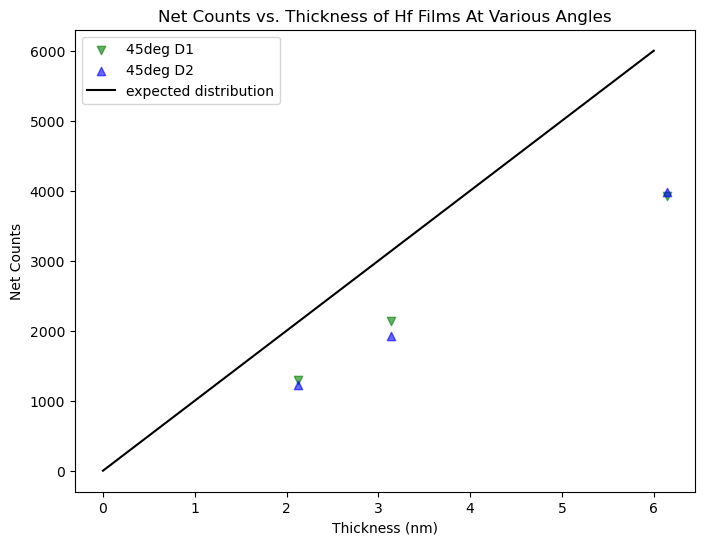

In [130]:
fig, ax = plt.subplots(figsize = (8,6))

thicknesses = [2.12, 3.14, 6.14]

x = np.linspace(0, 6, 50)
y = x

#plt.scatter(thicknesses, bruker_data['40deg D1'], c = 'r', marker = 'D', alpha = 0.6, label = '40deg D1')
#plt.scatter(thicknesses, bruker_data['40deg D2'], c = 'm', marker = 'o', alpha = 0.6, label = '40deg D2')

plt.scatter(thicknesses, bruker_data['45deg D1'], c = 'g', marker = 'v', alpha = 0.6, label = '45deg D1')
plt.scatter(thicknesses, bruker_data['45deg D2'], c =  'b', marker = '^', alpha = 0.6, label = '45deg D2')


plt.plot(x, y*1000, c = 'black', label = 'expected distribution')


ax.set_title("Net Counts vs. Thickness of Hf Films At Various Angles")
ax.set_xlabel("Thickness (nm)")
ax.set_ylabel("Net Counts")
plt.legend()
plt.show()
# ax.plot(data["60"][0],data["60"][2], color = cmap(0), label = "original signal")

# ax.plot(data["60"][0], data_peaks["60"][2], color = cmap(0.6), label= "Hf L2 peak")
# ax.plot(data["60"][0], data_peaks["60"][3], color = cmap(0.85), label= "Hf L3 peak")
# ax.legend()

#### 2.1.4 Analyzing which angles consistently yielded the strongest signal
**Analysis:**
To determine the best angle, we examine 1) the ratio between the counts for the three thicknesses measured, and 2) the raw number of Hf principal peak counts. We cross reference between the Pymca and Bruker data to ensure accuracy in the peak data. 

**(1)**
We check which angles contain count ratios consistent with the thickness of the film. This consistency provides confidence in the accuracy of the counts measured. 

The exact thicknesses are 2.12nm, 3.14nm, and 6.14nm. Given the 6nm film's Hf counts, we expect the 3.14nm film to have 51.14% of the 6nm's counts, and the 2.12nm film to have 34.53% of the 6nm's counts. 

We see that 38$\degree$, 40$\degree$, and 45$\degree$ best match these ratios for *both* Bruker and Pymca data. 

**(2)**
Out of 38$\degree$, 40$\degree$, and 45$\degree$, there is no clear angle with the highest counts consistently for all three thicknesses. They are all feasible angles for HfO2 films. 

**Next Step:**
We will find the averages of the 38$\degree$, 40$\degree$, and 45$\degree$ counts. We will plot these averaged counts and determine which one follows the most linear trend with respect to thickness to determine which angle is the most accurate for counting Hf. 

#### 2.1.5: 

## 2.2 Averaging the 45$\degree$ D2 Scans
**We have 10 scans at angle 45 detector 2. In this section, we average the fits of these scans to attain more comprehensive, accurate data. We examine the 6nm films because they provide the clearest peaks in isolation from background/diffraction noise.**

In [35]:
os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\interim\\K157_Rotation_45_D2_Fits")
rot_45D2_fits = {}
for i in range (10): 
    rot_45D2_fits[i] = readFitFile(glob.glob("20240729_K157_6nm_Rotation_45_deg_repeat_Rh_FE_D2_0_" + str(i) + 
                                                         "*.fit")[0])
avg_45D2 = {}
sum = 0
for k in range (5):
    avg_45D2[k] = np.zeros(len(rot_45D2_fits[0][0]))
    for j in range (len(rot_45D2_fits[0][0])):
        for i in range (10):
            sum += rot_45D2_fits[i][k][j]
        sum = sum / 10
        avg_45D2[k][j] = sum
        sum = 0

avg_45D2

{0: array([  69.,   70.,   71., ..., 2698., 2699., 2700.]),
 1: array([-0.27493098, -0.26491615, -0.25490133, ..., 26.05403946,
        26.06405428, 26.0740691 ]),
 2: array([0.7, 1.1, 1.4, ..., 9. , 9. , 9.9]),
 3: array([-1.70981654, -1.63128549, -1.5429466 , ..., 10.40970596,
        11.29042687, 11.72152216]),
 4: array([-1.70981654, -1.63128549, -1.5429466 , ..., 10.40970596,
        11.29042687, 11.72152216])}

## 2.3 Plotting the Fits

#### A. Plotting the 6nm HfO2 spectra, its fit curve from pymca, and the continuum (background radiation)

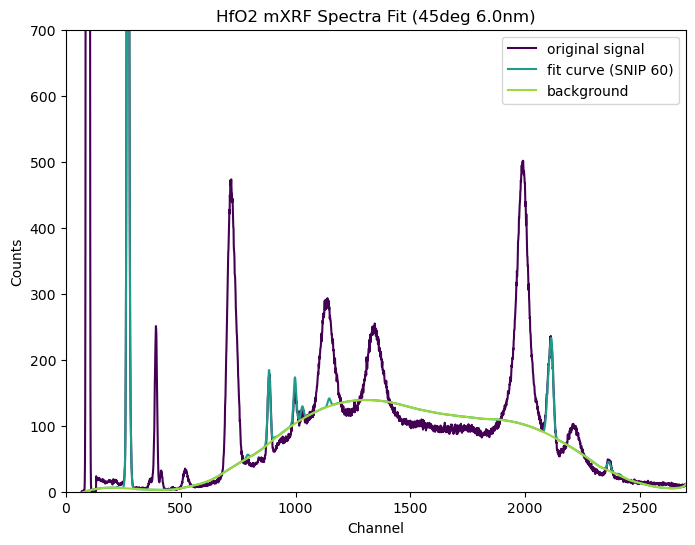

In [60]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlim(xmin = 0, xmax = 2700)
ax.set_ylim(ymin = 0, ymax = 700)

# ax.plot(data["60"][0],data["60"][2], color = cmap(0), label = "original signal")
# ax.plot(data["60"][0], data["60"][3], color = cmap(0.55), label = "fit curve (SNIP 60)" )
# ax.plot(data["60"][0],data["60"][4], color = cmap(0.85), label = "background (SNIP 60)")

ax.plot(avg_45D2[0], avg_45D2[2], color = cmap(0), label = "original signal")
ax.plot(avg_45D2[0], avg_45D2[3], color = cmap(0.55), label = "fit curve (SNIP 60)")
ax.plot(avg_45D2[0], avg_45D2[4], color = cmap(0.85), label = "background")


ax.legend()
ax.set_title("HfO2 mXRF Spectra Fit (45deg 6.0nm)")
ax.set_xlabel("Channel")
ax.set_ylabel("Counts")

#os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\processed\\figures")
#plt.savefig("HfO2_Spectra_SNIP60_40deg")

plt.show()

#### B. Zooming into the previous graph
*We separate this from the previous block of code because we want to save two different .png files*

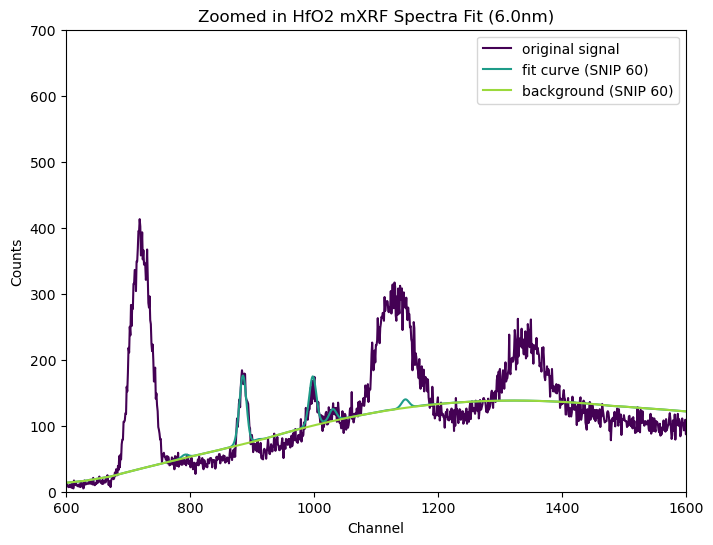

In [7]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlim(xmin = 600, xmax = 1600)
ax.set_ylim(ymin = 0, ymax = 700)

ax.plot(data["60"][0],data["60"][2], color = cmap(0), label = "original signal")
ax.plot(data["60"][0], data["60"][3], color = cmap(0.55), label = "fit curve (SNIP 60)" )
#ax.plot(data["30"][0], data["30"][3], color = 'r', label = "fit curve (SNIP 30)" )
#ax.plot(data["20"][0], data["20"][3], color = 'b', label = "fit curve (SNIP 20)" )
ax.plot(data["60"][0],data["60"][4], color = cmap(0.85), label = "background (SNIP 60)")

ax.legend()
ax.set_title("Zoomed in HfO2 mXRF Spectra Fit (6.0nm)")
ax.set_xlabel("Channel")
ax.set_ylabel("Counts")

#os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\processed\\figures")
#plt.savefig("Zoom_HfO2_Spectra_SNIP60_40deg")

plt.show()

## 3.0 Removing Background Radiation
#### A. Here, we subtract the continuum from the signal in an effort to isolate the fluorescence peaks.

In [5]:
# subtracts the background; returns an array of the spectra counts - continuum counts
# parameters: ydata_arr is the spectra counts (ydata), cont_arr is the continuum y-values
def cleanedSignal(ydata_arr, cont_arr): 
    if(len(ydata_arr) != len(cont_arr)): 
        raise ValueError("Arrays must be same length.")
    
    subtractbg = [0] * len(ydata_arr)
    for i in range(len(ydata_arr)): 
         subtractbg[i] = ydata_arr[i] - cont_arr[i]

    return subtractbg

#### B. Plotting the background radiation calculated from various SNIP fits

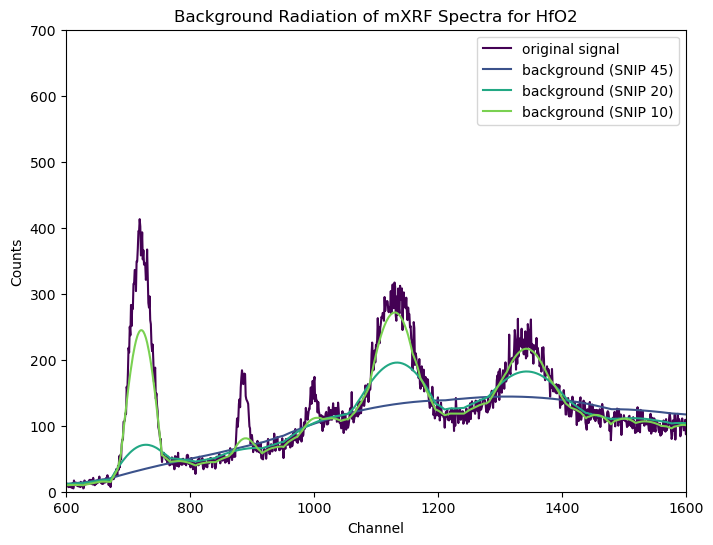

In [9]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlim(xmin = 600, xmax = 1600)
ax.set_ylim(ymin = 0, ymax = 700)
ax.plot(data["60"][0],data["60"][2], color = cmap(0), label = "original signal")
ax.plot(data["45"][0],data["45"][4], color = cmap(0.25), label = "background (SNIP 45)")
#ax.plot(data["30"][0],data["30"][4], color = cmap(0.4), label = "background (SNIP 30)")
ax.plot(data["20"][0],data["20"][4], color = cmap(0.6), label = "background (SNIP 20)")
ax.plot(data["10"][0],data["10"][4], color = cmap(0.8), label = "background (SNIP 10)")
ax.legend()
ax.set_ylabel("Counts")
ax.set_xlabel("Channel")
ax.set_title("Background Radiation of mXRF Spectra for HfO2")

#os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\processed\\figures")
#plt.savefig("Bg_HfO2_Spectra_SNIPs_40deg")
plt.show()

#### C. Plotting the "cleaned up" (background radiation removed) signals from various SNIP fits

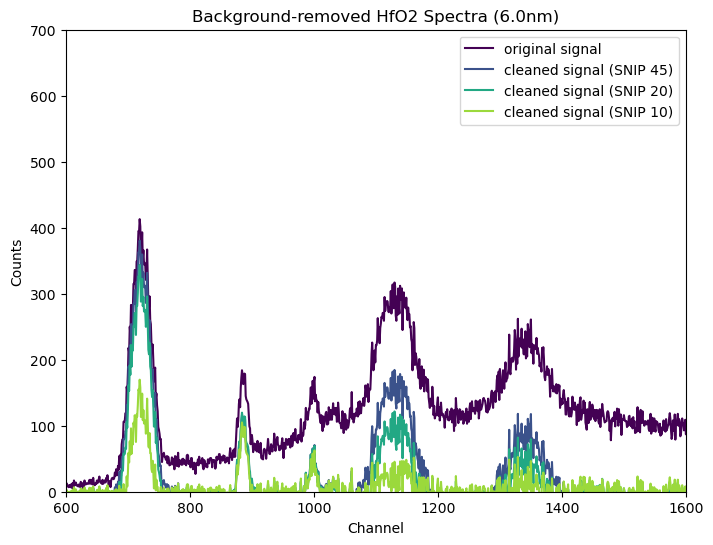

In [39]:
fig, ax = plt.subplots(figsize = (8,6))
ax.set_xlim(xmin = 600, xmax = 1600)
ax.set_ylim(ymin = 0, ymax = 700)

ax.plot(data["60"][0],data["60"][2], color = cmap(0), label = "original signal")
ax.plot(data["45"][0], cleanedSignal(data["45"][2], data["45"][4]), color = cmap(0.25), label = "cleaned signal (SNIP 45)")
#ax.plot(data["30"][0], cleanedSignal(data["30"][2], data["30"][4]), color = cmap(0.5), label = "cleaned signal (SNIP 30)")
ax.plot(data["20"][0], cleanedSignal(data["20"][2], data["20"][4]), color = cmap(0.6), label = "cleaned signal (SNIP 20)")
ax.plot(data["10"][0], cleanedSignal(data["10"][2], data["10"][4]), color = cmap(0.85), label = "cleaned signal (SNIP 10)")

ax.legend()
ax.set_ylabel("Counts")
ax.set_xlabel("Channel")
ax.set_title("Background-removed HfO2 Spectra (6.0nm)")

os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\processed\\figures")
plt.savefig("Noise_removed_HfO2_Spectra_SNIPs_40deg")

plt.show()

### 4.0 Which SNIP width is the best?
**In this section, we examine various SNIP widths under the best angle (determined from 2.1). Our goal is to determine which width best retains the Hf signal while balancing its computational cost. Lower SNIP widths are computationally more expensive, but tend to be more accurate in return. We want to determine which SNIP width balances these two trade-offs.**

In [46]:
os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\interim\\SNIP_widths_comparison\\")

In [57]:
data_6nm_40_SNIPs = {}
for i in ['5', '10', '20', '30', '45','60']:
    data_6nm_40_SNIPs[i] = readPeakCounts(glob.glob('20240626_K157_6nm_Rotation_40_deg_D1_0_8_SNIP' + i + '.fit')[0])[3].sum()

df_6nm_40_SNIPs = pd.DataFrame(data = data_6nm_40_SNIPs, index = ['40 deg counts'])
df_6nm_40_SNIPs



,5,10,20,30,45,60
40 deg counts,26.902109,228.531552,529.080239,1525.143933,1954.034563,1858.649437


### 2.3 Visualizing the Peak Fits

In [ ]:
# # WORK IN PROGRESS FOR MULTIPLE FILES
# os.chdir("C:\\Users\\sng38\\SURF_XRF_FY24\\surf_xrf_fy24\\data\\interim\\")
# data_peaks = {}
# for j in [0, 1, 2]:
#     for i in ["5", "10", "20", "30", "45", "60"]:
#         data_peaks[j][i] = readPeakCounts(glob.glob("20240626_K157_6nm_Rotation_40_deg_D1_tr8_" + i + "SNIP.fit")[0])

In [21]:
#MAKE 3 arrays/lists for each thickness. Each array will have 5 indices for the 5 SNIPS, giving the sum of L3
#create a DF from these 3 lists 

# peakL3_sums = {}
# for i in ["5", "10", "20", "30", "45", "60"]:
#     peakL3_sums[i] = data_peaks[i][3].sum()

# peak_sums = {}
# for i in ["5", "10", "20", "30", "45", "60"]:
#     for j in range(3):
#         peak_sums[i][j] = data_peaks[i][j+1].sum()

# test = {'5': [1, 2, 3], 
#         '10': [4, 5, 6]}
# testdf = pd.DataFrame(data = test, index = ['test1', 'test2', 'test3'])
# testdf
#peakL3_df = pd.DataFrame(data = peakL3_sums, index = ['6.0.nm', '3.0nm', '2.0nm'])
#peakL3_df